In [1]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 2662, done.
remote: Counting objects: 100% (1209/1209), done.
remote: Compressing objects: 100% (474/474), done.
remote: Total 2662 (delta 815), reused 870 (delta 718), pack-reused 1453 (from 1)
Receiving objects: 100% (2662/2662), 24.03 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (1560/1560), done.


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [3]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB

In [4]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.visualization import plot_predictions

In [5]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [79]:
import yfinance as yf
import pandas as pd
from datetime import timedelta

# Define the ticker symbol for Apple
ticker = "AAPL"

# Define the prediction start date and context length (512 valid data points)
prediction_start_date = pd.to_datetime("2023-04-05")
context_length = 1024

# Fetch more data than needed (2x the context length, for example) to account for missing values
buffer_days = 2 * context_length
data_start_date = prediction_start_date - timedelta(days=buffer_days)

# Fetch the data starting from the calculated start date
data = yf.download(ticker, start=data_start_date.strftime('%Y-%m-%d'), end="2024-01-01")

# Drop missing values to keep only valid data
data_resampled = data.dropna()

# Select only the 'Close' price and reset the index
apple_stock_data = data_resampled[['Close']].reset_index()

data_after = yf.download(ticker, start=prediction_start_date.strftime('%Y-%m-%d'), end="2024-01-01")

# Reset index to have consistent indices
data_after_cleaned = data_after.dropna()[['Close']].reset_index()

# Concatenate the two datasets (before and after)
apple_stock_data = pd.concat([apple_stock_data[apple_stock_data['Date'] < prediction_start_date].tail(context_length), data_after_cleaned])


# Display the first few rows to check the data
print(apple_stock_data.head())
print(f"Data starts from: {last_valid_data['Date'].min().strftime('%Y-%m-%d')}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

          Date      Close
386 2019-03-13  45.427502
387 2019-03-14  45.932499
388 2019-03-15  46.529999
389 2019-03-18  47.005001
390 2019-03-19  46.632500
Data starts from: 2021-03-24


In [80]:
apple_stock_data

,Date,Close
386,2019-03-13,45.427502
387,2019-03-14,45.932499
388,2019-03-15,46.529999
389,2019-03-18,47.005001
390,2019-03-19,46.632500
...,...,...
181,2023-12-22,193.600006
182,2023-12-26,193.050003
183,2023-12-27,193.149994
184,2023-12-28,193.580002


In [81]:
# Select the relevant columns and rename 'Datetime' to 'timestamp'
apple_stock_data = apple_stock_data[['Date', 'Close']]
apple_stock_data.rename(columns={'Date': 'timestamp', 'Close': 'close'}, inplace=True)

# Normalize the 'close' prices
# apple_stock_data['close'] = (apple_stock_data['close'] - apple_stock_data['close'].mean()) / apple_stock_data['close'].std()

# Save the processed data to a CSV file
apple_stock_data.to_csv('/content/apple_stock_2023.csv', index=False)

# Display the first few rows to verify the data
apple_stock_data


,timestamp,close
386,2019-03-13,45.427502
387,2019-03-14,45.932499
388,2019-03-15,46.529999
389,2019-03-18,47.005001
390,2019-03-19,46.632500
...,...,...
181,2023-12-22,193.600006
182,2023-12-26,193.050003
183,2023-12-27,193.149994
184,2023-12-28,193.580002


In [82]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

forecast_length=1

target_dataset = "apple_stock_2023"
DATA_ROOT_PATH = "/content/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "1024_96_v1"

In [83]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [84]:
len(apple_stock_data),

(1210,)

In [85]:

    timestamp_column = "timestamp"
    id_columns = []
    target_columns = ["close"]

    # Understanding the split config -- slides

    data = pd.read_csv(
        '/content/apple_stock_2023.csv',
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": [],
    }

    ts_preprocessor = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        # scaling=True,
        encode_categorical=False,
        # scaler_type=None,
    )



In [86]:
from typing import Any, Dict, Generator, List, Optional, Tuple, Union
from datasets import Dataset
from tsfm_public.toolkit.dataset import ForecastDFDataset
def get_single_dataset(
    ts_preprocessor: TimeSeriesPreprocessor,
    dataset: Union[Dataset, pd.DataFrame],
    stride: int = 1,
    as_univariate: bool = False,
    use_frequency_token: bool = False,
) -> Any:
    """Creates the preprocessed pytorch dataset for the entire dataset without any splits.

    Args:
        dataset (Union[Dataset, pd.DataFrame]): Loaded pandas dataframe.
        stride (int): Stride used for creating the dataset. Defaults to 1.
        as_univariate (bool, optional): When True the dataset returned will contain only one target column. An
            additional ID is added to distinguish original column name. Only valid if there are no exogenous
            specified. Defaults to False.
        use_frequency_token (bool): If True, dataset is created that includes the frequency token. Defaults to False.

    Returns:
        A pytorch dataset.
    """

    if not ts_preprocessor.context_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null context_length")
    if not ts_preprocessor.prediction_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null prediction_length")

    data = ts_preprocessor._standardize_dataframe(dataset)

    # Train data preprocessing
    ts_preprocessor.train(data)

    # Specify columns
    column_specifiers = {
        "id_columns": ts_preprocessor.id_columns,
        "timestamp_column": ts_preprocessor.timestamp_column,
        "target_columns": ts_preprocessor.target_columns,
        "observable_columns": ts_preprocessor.observable_columns,
        "control_columns": ts_preprocessor.control_columns,
        "conditional_columns": ts_preprocessor.conditional_columns,
        "static_categorical_columns": ts_preprocessor.static_categorical_columns,
    }

    params = column_specifiers
    params["context_length"] = ts_preprocessor.context_length
    params["prediction_length"] = ts_preprocessor.prediction_length
    params["stride"] = stride
    if use_frequency_token:
        params["frequency_token"] = ts_preprocessor.get_frequency_token(ts_preprocessor.freq)

    # Preprocess data
    data_prep = ts_preprocessor.preprocess(data)
    print(len(data_prep))



    return ForecastDFDataset(data_prep, **params)


In [87]:
   train_dataset = get_single_dataset(
        ts_preprocessor,data
    )

1210


In [88]:
 zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )

In [89]:
len(train_dataset)

186

In [90]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Loop through each data point in the training dataset
for i, data_point in enumerate(train_dataset):
    # Extract past values, actual future values, and the prediction timestamp
    past_values = data_point["past_values"]
    actual_values = data_point["future_values"]
    timestamp = data_point["timestamp"]

    # Forward pass through the model
    output = zeroshot_model.forward(past_values.unsqueeze(0), return_loss=False)

    # Extract the predicted values
    predicted_values = output.prediction_outputs.squeeze(0).tolist()  # Convert to list

    # Convert actual values to list
    actual_values_list = actual_values.squeeze(0).tolist()  # Ensure it's a list
    prediction_date = pd.to_datetime(timestamp) + pd.Timedelta(days=1)
    # Collect data for each prediction
    result = {
        "start_past_values": past_values[0].item(),
        "end_past_values": past_values[-1].item(),
        "prediction_date": prediction_date,  # Store the timestamp of the prediction
        "predicted_values": predicted_values,  # Store all predicted values as a list
        "actual_values": actual_values_list  # Store all actual values as a list
    }

    results.append(result)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)




In [91]:
results_df

,start_past_values,end_past_values,prediction_date,predicted_values,actual_values
0,45.427502,165.630005,2023-04-05,"[[167.1593780517578], [166.59548950195312], [1...",[163.75999450683594]
1,45.932499,163.759995,2023-04-06,"[[164.77676391601562], [164.59036254882812], [...",[164.66000366210938]
2,46.529999,164.660004,2023-04-07,"[[165.6116943359375], [165.18203735351562], [1...",[162.02999877929688]
3,47.005001,162.029999,2023-04-11,"[[162.28517150878906], [162.172119140625], [16...",[160.8000030517578]
4,46.632500,160.800003,2023-04-12,"[[160.812255859375], [160.79200744628906], [15...",[160.10000610351562]
...,...,...,...,...,...
181,66.959999,194.679993,2023-12-22,"[[194.5894775390625], [195.62066650390625], [1...",[193.60000610351562]
182,66.812500,193.600006,2023-12-23,"[[193.9525146484375], [195.00099182128906], [1...",[193.0500030517578]
183,66.040001,193.050003,2023-12-27,"[[193.86868286132812], [194.8331298828125], [1...",[193.14999389648438]
184,64.862503,193.149994,2023-12-28,"[[194.21151733398438], [195.257080078125], [19...",[193.5800018310547]


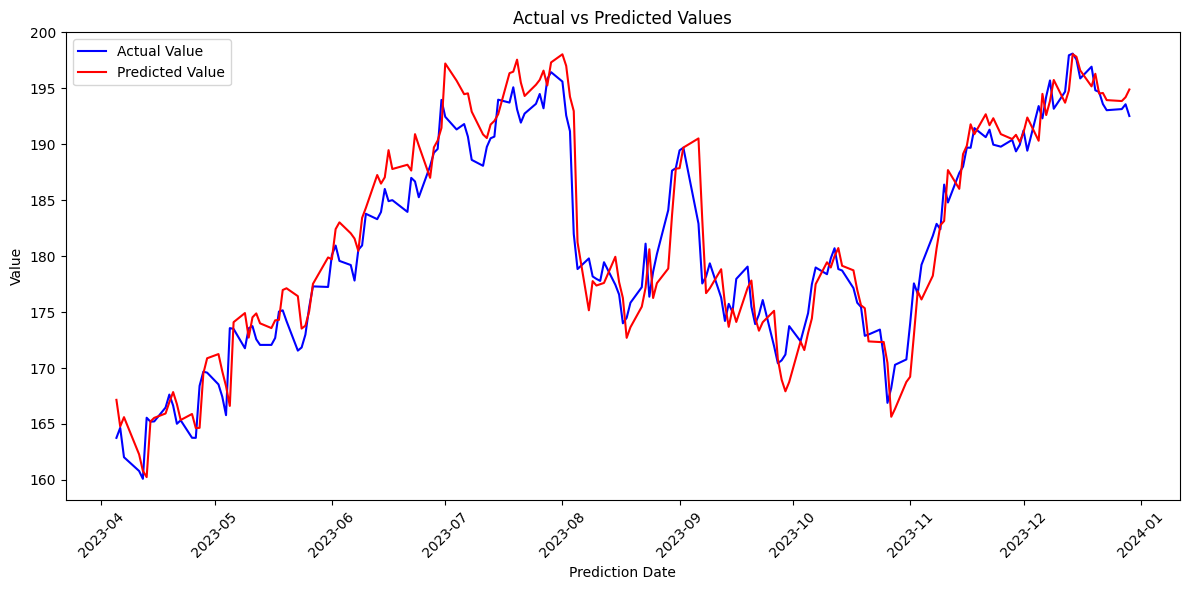

In [92]:
import matplotlib.pyplot as plt

# Extract the first predicted and first actual values along with the prediction dates
prediction_dates = results_df['prediction_date']
first_predicted_values = [pred[0] for pred in results_df['predicted_values']]
first_actual_values = [actual[0] for actual in results_df['actual_values']]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(prediction_dates, first_actual_values, label='Actual Value', color='blue', )

# Plot the predicted values
plt.plot(prediction_dates, first_predicted_values, label='Predicted Value', color='red',)

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Prediction Date')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [93]:
import numpy as np
results_df['first_predicted_value'] = results_df['predicted_values'].apply(lambda x: x[0][0] if isinstance(x, (list, np.ndarray)) else x)
results_df['first_actual_value'] = results_df['actual_values'].apply(lambda x: x[0])

# Create a new DataFrame with the necessary columns
context_results_df = pd.DataFrame({
    'y_actual': results_df['first_actual_value'],
    'raw_forecast': results_df['first_predicted_value'],
    'prediction_date': results_df['prediction_date']
})
context_results_df


,y_actual,raw_forecast,prediction_date
0,163.759995,167.159378,2023-04-05
1,164.660004,164.776764,2023-04-06
2,162.029999,165.611694,2023-04-07
3,160.800003,162.285172,2023-04-11
4,160.100006,160.812256,2023-04-12
...,...,...,...
181,193.600006,194.589478,2023-12-22
182,193.050003,193.952515,2023-12-23
183,193.149994,193.868683,2023-12-27
184,193.580002,194.211517,2023-12-28


In [94]:
context_results_df=context_results_df[:-1]
context_results_df

,y_actual,raw_forecast,prediction_date
0,163.759995,167.159378,2023-04-05
1,164.660004,164.776764,2023-04-06
2,162.029999,165.611694,2023-04-07
3,160.800003,162.285172,2023-04-11
4,160.100006,160.812256,2023-04-12
...,...,...,...
180,194.679993,194.536713,2023-12-21
181,193.600006,194.589478,2023-12-22
182,193.050003,193.952515,2023-12-23
183,193.149994,193.868683,2023-12-27


In [97]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score


# Define the calculation functions (same as before)
def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, context_results_df):
    # Use the provided DataFrame directly
    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # Compile the results into a DataFrame
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# Calculate the results for the provided context_results_df
final_result_df = calculate_results_for_context_len(context_length, context_results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0         1024  6.889697   0.48913            0.521739   

   actual_direction_accuracy  direction_profit     profit  
0                    0.48913         14.955061  10.615839  


In [98]:
def calculate_buy_and_hold_profit(context_results_df, initial_capital=100):
    """
    Calculate the profit from a buy-and-hold strategy.

    Args:
    - context_results_df (DataFrame): DataFrame containing actual prices.
    - initial_capital (float): The starting amount of money.

    Returns:
    - float: The profit from a buy-and-hold strategy.
    """
    # Buy at the first available price
    first_price = context_results_df['y_actual'].iloc[0]

    # Sell at the last available price
    last_price = context_results_df['y_actual'].iloc[-1]

    # Calculate the number of shares bought initially
    shares = initial_capital / first_price

    # Final capital after selling all shares at the last price
    final_capital = shares * last_price

    # Profit is the final capital minus the initial capital
    profit = final_capital - initial_capital

    return profit

# Assuming `context_results_df` is already prepared as in the previous code
buy_and_hold_profit = calculate_buy_and_hold_profit(context_results_df)
print(f"Buy and Hold Profit: {buy_and_hold_profit}")


Buy and Hold Profit: 18.209580071141218
